# Using RandomForestClassification to determine probability of adverse events for each covid related vaccine

In [31]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib
import pandas as pd
import tensorflow as tf
%matplotlib inline

# Import our input dataset
vaxsymp = pd.read_csv('../Resources/Data/MLdata.csv')
# vaxsymp = vaxsymp.set_index(["VAERS_ID"])
vaxsymp.head(10)

,VAERS_ID,AGE_YRS,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,AGE_BIN,VAX_MANU,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5
0,916600,33.0,F,N,N,N,N,N,N,19-40,MODERNA,Dysphagia,Epiglottitis,0,0,0
1,916601,73.0,F,N,N,N,N,N,N,61-80,MODERNA,Anxiety,Dyspnoea,0,0,0
2,916602,23.0,F,N,N,N,N,N,N,19-40,PFIZER\BIONTECH,Chest discomfort,Dysphagia,Pain in extremity,Visual impairment,0
3,916603,58.0,F,N,N,N,N,N,N,41-60,MODERNA,Dizziness,Fatigue,Mobility decreased,0,0
4,916604,47.0,F,N,N,N,N,N,N,41-60,MODERNA,Injection site erythema,Injection site pruritus,Injection site swelling,Injection site warmth,0
5,916606,44.0,F,N,N,N,N,N,N,41-60,MODERNA,Pharyngeal swelling,0,0,0,0
6,916607,50.0,M,N,N,N,N,N,N,41-60,MODERNA,Abdominal pain,Chills,Sleep disorder,0,0
7,916608,33.0,M,N,N,N,N,N,N,19-40,MODERNA,Diarrhoea,Nasal congestion,0,0,0
8,916609,71.0,F,N,N,N,N,N,N,61-80,MODERNA,Vaccination site erythema,Vaccination site pruritus,Vaccination site swelling,0,0
9,916610,18.0,F,N,N,N,N,N,N,0-18,MODERNA,Rash,Urticaria,0,0,0


# Using LabelEncoder to assign unique values to the symptom columns

In [2]:
# Creating LabelEncoder instance
df2 = vaxsymp.copy()
df2[['DIED','ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','AGE_BIN','VAX_MANU','L_THREAT','SEX','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4','SYMPTOM5']] = df2[['DIED','ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','AGE_BIN','VAX_MANU','L_THREAT','SEX','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4','SYMPTOM5']].apply(preprocessing.LabelEncoder().fit_transform)
df2.head(5)

,VAERS_ID,AGE_YRS,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,AGE_BIN,VAX_MANU,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5
0,916600,33.0,0,0,0,0,0,0,0,2,1,34284,27812,0,0,0
1,916601,73.0,0,0,0,0,0,0,0,4,1,9836,26406,0,0,0
2,916602,23.0,0,0,0,0,0,0,0,2,2,27779,26178,28731,24770,0
3,916603,58.0,0,0,0,0,0,0,0,3,1,33330,29123,27911,0,0
4,916604,47.0,0,0,0,0,0,0,0,3,1,38168,33432,26644,20727,0


In [3]:
# Use OneHotEncoder 
enc = OneHotEncoder(sparse=False)

# Fit and transform using catagorical variable lists
encode_df = pd.DataFrame(enc.fit_transform(df2[['DIED','ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','AGE_BIN','VAX_MANU','L_THREAT','SEX']]))

# Add the names to the list
encode_df.columns = enc.get_feature_names(['DIED','ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','AGE_BIN','VAX_MANU','L_THREAT','SEX'])
encode_df.head(5)

,DIED_0,DIED_1,ER_VISIT_0,ER_VISIT_1,HOSPITAL_0,HOSPITAL_1,DISABLE_0,DISABLE_1,BIRTH_DEFECT_0,BIRTH_DEFECT_1,...,AGE_BIN_5,VAX_MANU_0,VAX_MANU_1,VAX_MANU_2,VAX_MANU_3,L_THREAT_0,L_THREAT_1,SEX_0,SEX_1,SEX_2
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [4]:
# Merge one-hot encoded features and drop the originals
df3 = df2.merge(encode_df, left_index=True, right_index=True)
df3 = df3.drop(columns = ['AGE_YRS','DIED','ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','AGE_BIN','VAX_MANU','L_THREAT','SEX'])
df3 = df3.set_index(['VAERS_ID']) 
df3.head() 

,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,DIED_0,DIED_1,ER_VISIT_0,ER_VISIT_1,HOSPITAL_0,...,AGE_BIN_5,VAX_MANU_0,VAX_MANU_1,VAX_MANU_2,VAX_MANU_3,L_THREAT_0,L_THREAT_1,SEX_0,SEX_1,SEX_2
VAERS_ID,,,,,,,,,,,,,,,,,,,,,
916600,34284,27812,0,0,0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
916601,9836,26406,0,0,0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
916602,27779,26178,28731,24770,0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
916603,33330,29123,27911,0,0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
916604,38168,33432,26644,20727,0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [5]:
df3.columns

Index(['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5', 'DIED_0',
       'DIED_1', 'ER_VISIT_0', 'ER_VISIT_1', 'HOSPITAL_0', 'HOSPITAL_1',
       'DISABLE_0', 'DISABLE_1', 'BIRTH_DEFECT_0', 'BIRTH_DEFECT_1',
       'AGE_BIN_0', 'AGE_BIN_1', 'AGE_BIN_2', 'AGE_BIN_3', 'AGE_BIN_4',
       'AGE_BIN_5', 'VAX_MANU_0', 'VAX_MANU_1', 'VAX_MANU_2', 'VAX_MANU_3',
       'L_THREAT_0', 'L_THREAT_1', 'SEX_0', 'SEX_1', 'SEX_2'],
      dtype='object')

# Use Standard Scaler to scale the data

In [22]:
# drop SYMPTOM1 target from features data
y = df3.AGE_BIN_3
X = df3.drop(columns=['AGE_BIN_1','AGE_BIN_2','AGE_BIN_3','AGE_BIN_4','AGE_BIN_5','DIED_0'])

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Use RandomForestClassifier for our prediction 

In [23]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=42)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.582


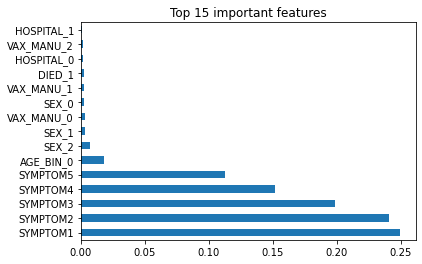

In [35]:
#visualize the top 15 important features
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [8]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
# sfm = SelectFromModel(rf_model, threshold=0.15)

# # Train the selector
# sfm.fit(X_train_scaled, y_train)

# # Print the names of the most important features
# for feature_list_index in sfm.get_support(indices=True):
#     print(feat_labels[feature_list_index])

In [9]:
# # Define the model - deep neural net
# number_input_features = len(X_train_scaled[0])
# hidden_nodes_layer1 =  24
# hidden_nodes_layer2 = 12

# nn = tf.keras.models.Sequential()

# # First hidden layer
# nn.add(
#     tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
# )

# # Second hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# # Output layer
# nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# # Compile the Sequential model together and customize metrics
# nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# # Train the model
# fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

# # Evaluate the model using the test data
# model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")